In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [12]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        qv = Q[observation]
        policy = np.ones(nA) * epsilon/nA
        a = np.argmax(qv)
        policy[a] = policy[a] + 1-epsilon
        return policy
        
        # Implement this!
    return policy_fn

In [66]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i in range(num_episodes):
        episode = []
        state = env.reset()
        for t in range(100):
            actionP = policy(state)
            action = np.random.choice(env.action_space.n, 1, p=actionP)[0]
            Newstate, reward, done, __ = env.step(action)
            episode.append((state,action,reward))
            if(done):
                # print('Episode', episode)
                break
                
            state = Newstate
        
        # reflect on episode
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        
        # for every unique state
        for state,action in sa_in_episode:
            first_occurence = len(episode)-1
            for i in range(len(episode)):
                if(episode[i][0] == state and episode[i][1] == action):
                    first_occurence = i
                    break
            returns = sum(discount_factor**i * x[2] for i,x in enumerate(episode[first_occurence:]))
            returns_sum[(state,action)] += returns
            returns_count[(state,action)] += 1.0
            Q[state][action] = returns_sum[(state,action)]/returns_count[(state,action)]
            # print('State,Action,First,Returns',state, action, first_occurence, returns)
            
    return Q, policy

In [67]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, discount_factor=1.0,epsilon=0.1)

for state, action in Q.items():
    pass
    # print(state, action)

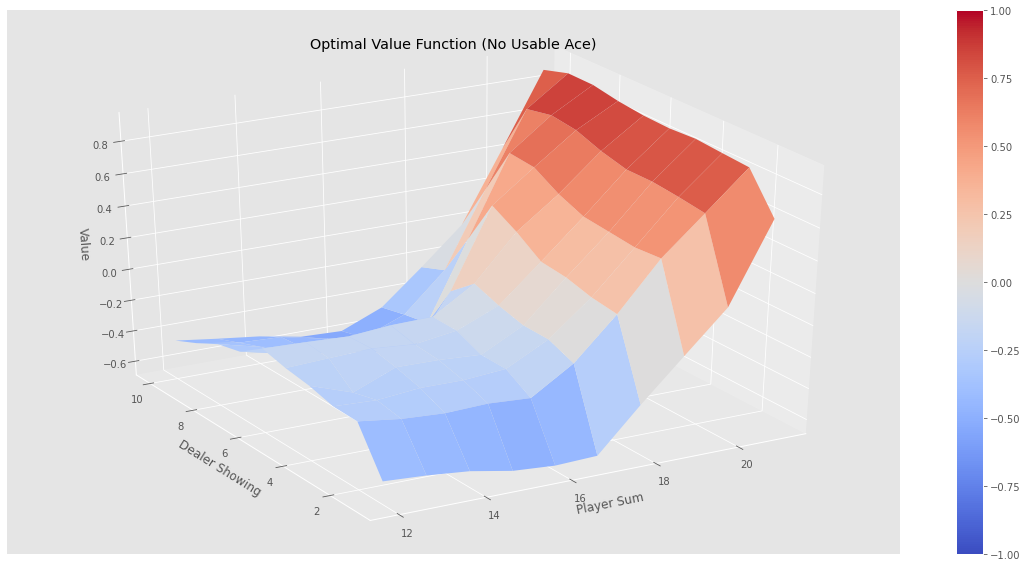

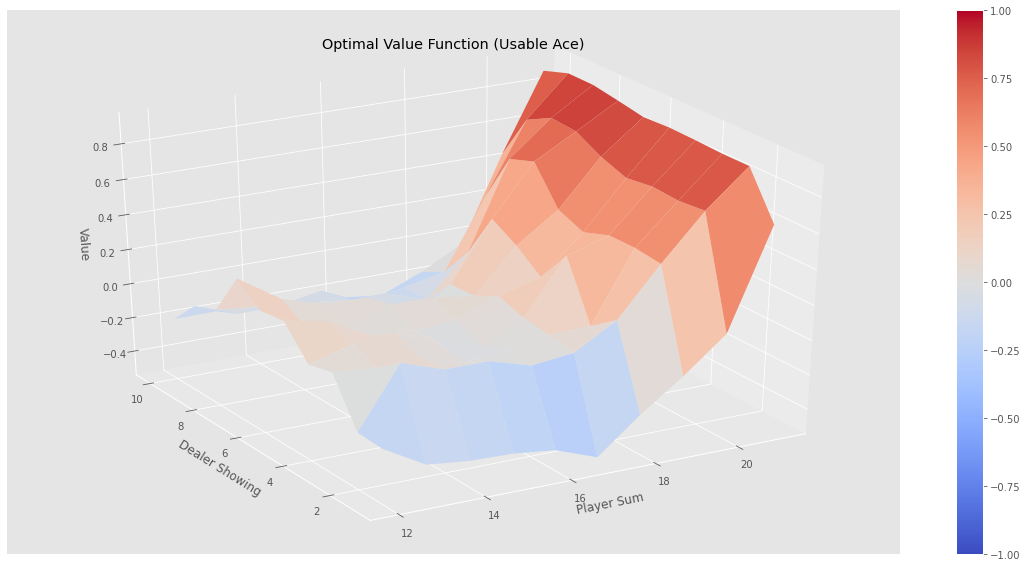

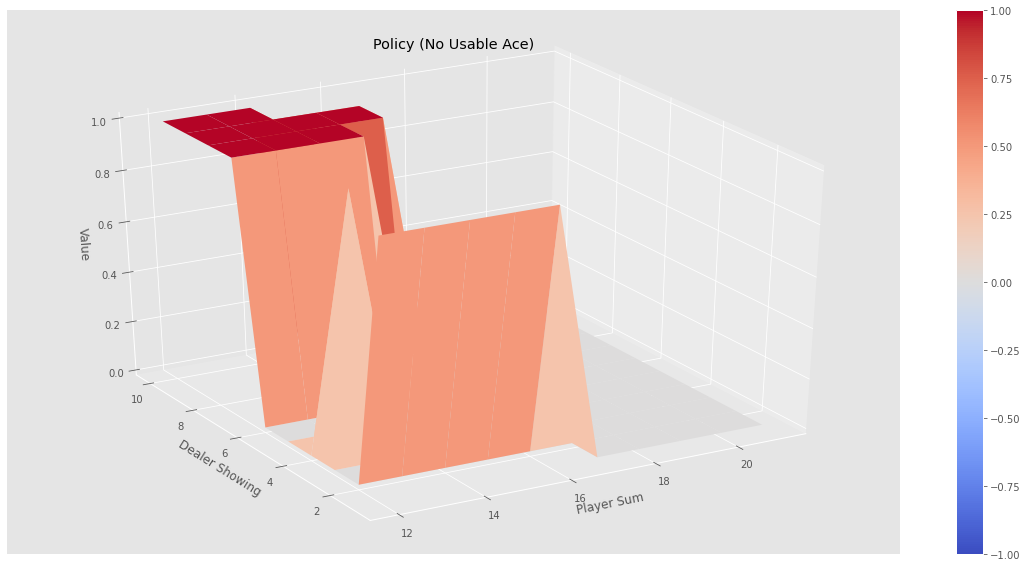

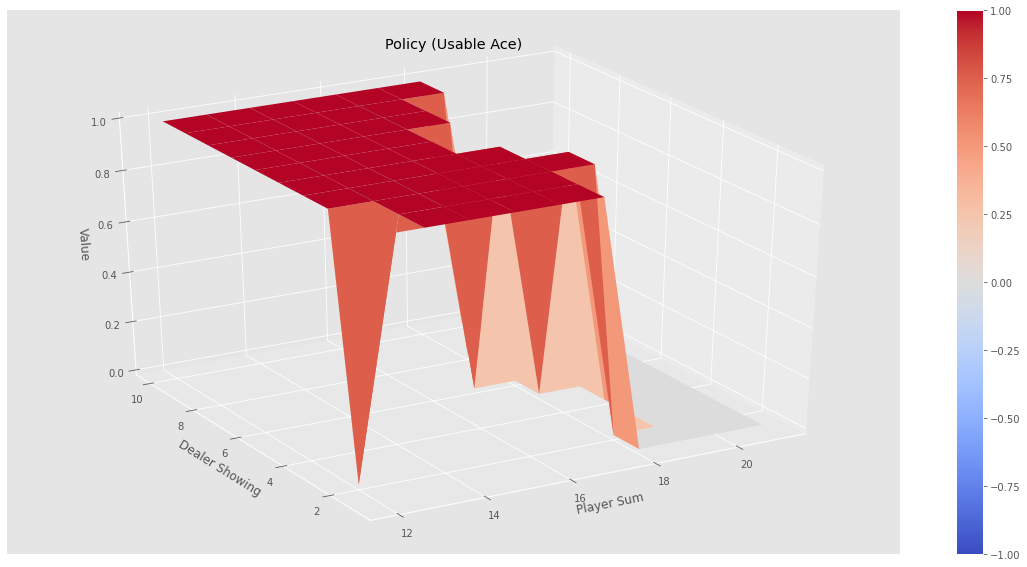

In [69]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
Pi = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    action = np.argmax(actions)
    Pi[state] = action
    V[state] = action_value
    # print(state, V[state])
plotting.plot_value_function(V, title="Optimal Value Function")
plotting.plot_value_function(Pi, title="Policy")